# Chapter 10: Beam Theory: Architecture for Cells and Skeletons 

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd
import sympy

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the default plotting style
import plotting_style as pstyle

# Function to import and display images from the Garland website
from IPython.display import Image

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# Define directories
figdir = '../fig/'

In [2]:
# Set plotting style
pstyle.set_plotting_style()
# Set dpi for inline figures
mpl.rcParams['figure.dpi'] = 110

## 10.1 D Persistence length and Fourier analysis

d) Make use of the identity $\left\langle \cos X \right\rangle = e^{−\left\langle X^2 \right\rangle/2}$, which holds for a Gaussian distributed random variable $X$, to obtain the equation for the tangent–tangent correlation function, $\left\langle t(s) \cdot t(0)\right\rangle = e^{−\theta(s)^2 / 2}$. Then compute $\left\langle \theta(s)^2\right\rangle$ by using the Fourier series representation of $\theta (s)$ and the average values of the Fourier amplitudes $\tilde \theta$ obtained in (c). Convince yourself either by plotting or Fourier analysis that on the interval $0 < s < L$, $\left\langle \theta(s)^2\right\rangle = {s \over \xi_p}$.

### Solution

We arrived to the solution that the average value of the angle squared $\left\langle \theta(s)^2\right\rangle$ is of the form
$$
\left\langle \theta(s)^2\right\rangle = {L \over \xi_p}
\sum_{n = 1}^\infty {8 \over [(2n -1)\pi]^2} 
\sin^2\left( {(2n - 1)\pi \over 2L}s \right).
$$
Let's define a function that performs this sum up to a specific $n$ and see to which value it converges as we add more and more terms.

In [3]:
def avg_theta_sqr(n, s, L=1, xi_p=0.1):
    '''
    Computes the average value of the angle squared
    '''
    # Initialize array to save each entry for each n and s value
    theta_sq = np.zeros([n, len(s)])
    
    # Loop through n and compute s
    for i in range(1, n + 1):
        theta_sq[i-1, :] = (L / xi_p) * (8 / ((2 * i - 1) * np.pi)**2) *\
                         np.sin((2 * i - 1) * np.pi / (2 * L) * s)**2
        
    return theta_sq

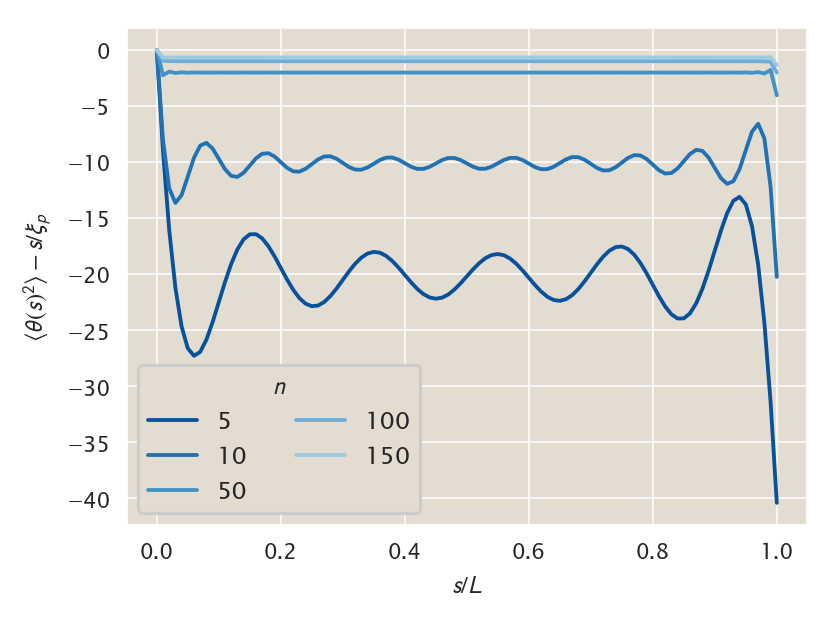

In [4]:
# Define range of s values
L = 1
s_array = np.linspace(0, L, 101)
xi_p = L / 1000

# Compute sum up to 100
theta_sq = avg_theta_sqr(150, s_array, L, xi_p)

##   Plot partial sums

# Define partial sums to plot
n_plot = [5, 10, 50, 100, 150]

# Define colors
colors = sns.color_palette('Blues_r', n_colors=len(n_plot)+2)

# Loop through partial plots
for i, n in enumerate(n_plot):
    # Plot partial sum
    plt.plot(s_array, theta_sq[0:n, :].sum(axis=0) - s_array / xi_p,
             label=str(n), color=colors[i])

# Label axis
plt.xlabel(r'$s / L$')
plt.ylabel(r'$\left\langle \theta(s)^2 \right\rangle - s / \xi_p$')

# Add legend
plt.legend(title='$n$', ncol=2)

# Save figure
plt.savefig(figdir + 'problem_10_01_04.png', bbox_inches='tight',
            dpi=300)

## 10.5 Packing free energy for a spherical virus

Repeat the calculations of the energy of DNA packing for a spherical capsid. Contrast this result with that obtained in the chapter where it was assumed that the capsid is a cylinder. Use the experimental data provided on the book’s website and compare the model with the data shown in Figure 10.19(B).

### Solution

The free energy of assembly for a spherical virus is divided into two components:
$$
G_{virus} = G_{bend} + G_{charge},
$$
where $G_{bend}$ is the energy cost for bending the DNA and $G_{charge}$ is the energy associated with bringing charges close together.

For the problem we derived the bending energy to be of the form
$$
G_{bend} = {4 \pi \xi_p k_BT \over \sqrt{3} d_s^2} R_{out}
\left[ {1 \over 2} \log\left( {1 + x \over 1 - x} \right) - x\right],
$$
where 
$$
x \equiv \left( {3\sqrt{3} d_s^2 L \over 8 \pi R_{out}^3} \right)^{2/3},
$$
is a dimensionless quantity that relates the volume of the packed DNA to the volume of the capsid. $\xi_p$ is the persistence length, $d_s$ is the spacing between DNA strands, $L$ is the length of the packed genome, and $R_{out}$ is the radius of the spherical capsid. 

The free energy of charge interaction is very difficult to calculate from "first principles". Therefore the prophets take an empirical approach based on some data that shows that as a function of the interspacing between strands the osmotic pressure $p(d_s)$ can be fit by an exponential curve of the form
$$
p(d_s) = F_0 e^{-d_s / c},
$$
where $F_0$ and $c$ are constants to be obtained from data. From this form of the osmotic pressure we can build the energy of charge interaction that takes the form
$$
G_{charge} = \sqrt{3} F_0 \left(c^2 + c d_s  \right)L e^{- d_s / c}.
$$

To make progress we need to find the value of the constants $F_0$ and $c$ from the osmotic pressure vs ineraxial spacing. This is shown in the boox in Fig. 6.24. Here I will import the data. I manually turned this data into tidy format because the excel was hard to import as it originally stands.

In [5]:
# Read data into memory
df = pd.read_excel('../data/fig6.24.xls', sheet_name='tidy')

df.head()

,salt_M,spacing_angstroms,log_pressure_dyne_cm2
0,0.1,38.108328,6.707046
1,0.1,35.583976,6.774559
2,0.1,33.595808,6.970460
3,0.1,32.202357,7.055454
4,0.1,31.010081,7.191798


Having read this into memory let's reproduce Fig. 6.24. For this we consider that 10 angstroms = 1 nm and 1 dyne/cm$^2$ = 0.1 N/m$^2$.

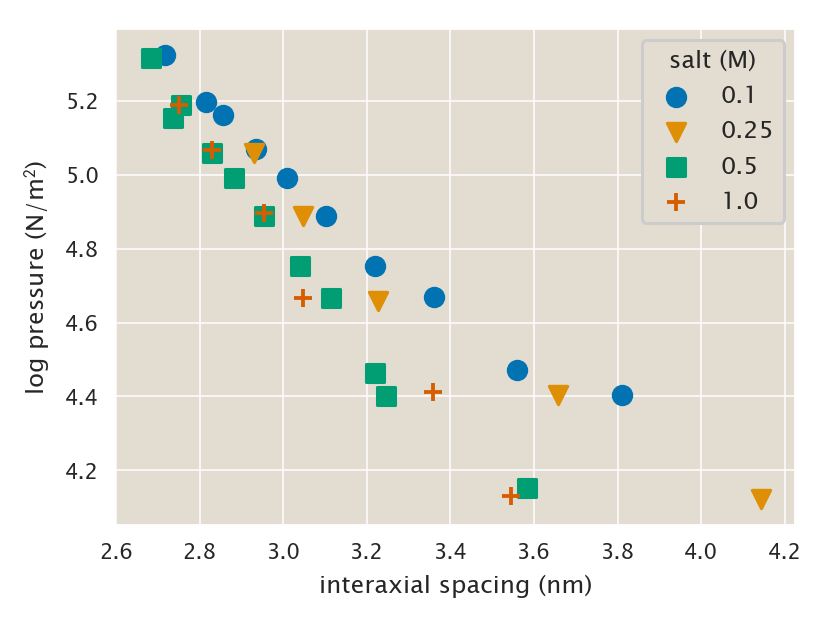

In [6]:
# Add column with log pressure in N/m^2
df['log_pressure_N_m2'] = np.log(np.exp(df.log_pressure_dyne_cm2) * 0.1)

# group data by salt concentration
df_group = df.groupby('salt_M')

# Define list of markers
markers = ['o', 'v', 's', '+']

# Loop through concentrations to plot data
for i, (group, data) in enumerate(df_group):
    plt.scatter(data.spacing_angstroms / 10,
                data.log_pressure_N_m2,
                label=group, marker=markers[i])
    
# Label axis
plt.xlabel('interaxial spacing (nm)')
plt.ylabel('log pressure (N/m$^2$)')

# Add legend
_ = plt.legend(title='salt (M)')

From this data we can fit the parameters $F_0$ and $c$ by simply performing a linear regression on the log of the pressure. This takes the form
$$
\log p(d_s) = \log F_0 - d_s / c.
$$
A proper extensive analysis would require us to do the fitting not in log scale but in linear scale with the proper estimation of error bars. But we'll leave that for another problem. For now we will simply use numpy to find the slope and intercept that best describes this data.

In [7]:
# Perform simple linear regression on data
linear_fit = np.polyfit(df.spacing_angstroms / 10,
                        df.log_pressure_N_m2,
                        deg=1)

# Find parameters
Fo = np.exp(linear_fit[1])
c = - 1 / linear_fit[0]

# Print parameters
print('Parameter values:')
print('Fo = {:.1f} N/m^2'.format(Fo))
print('c = {:.1f} nm'.format(c))

Parameter values:
Fo = 2114.0 N/m^2
c = 1.1 nm


Let's see how well these parameters fit the data

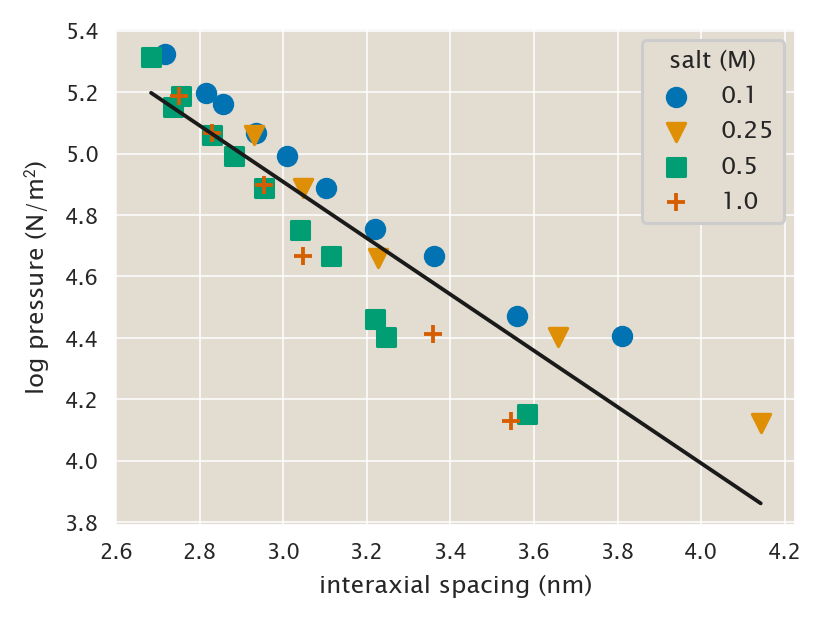

In [8]:
# Define range for linear fit
ds_range = np.linspace(df.spacing_angstroms.min() / 10,
                       df.spacing_angstroms.max() / 10)
log_pressure = linear_fit[1] + ds_range * linear_fit[0]

# group data by salt concentration
df_group = df.groupby('salt_M')

# Define list of markers
markers = ['o', 'v', 's', '+']

# Loop through concentrations to plot data
for i, (group, data) in enumerate(df_group):
    plt.scatter(data.spacing_angstroms / 10,
                data.log_pressure_N_m2,
                label=group, marker=markers[i])
    
# Plot best fit line
plt.plot(ds_range, log_pressure, label='', color='k')

# Label axis
plt.xlabel('interaxial spacing (nm)')
plt.ylabel('log pressure (N/m$^2$)')

# Add legend
_ = plt.legend(title='salt (M)')

There are possibly a lot of sloptes and intercepts that would fit this data. So a more formal analysis would require a Bayesian approach to consider the uncertainty on these fit parameters.

Having found values for this let's now read the relevant data to compare our theoretical model. The data is presented in the book as Fig. 10.19(B) where the percentage of genome packed is plotted against the internal force as measured with optical tweezers. Let's again import the data that I manually fit into a tidy format and plot it to reproduce the figure.

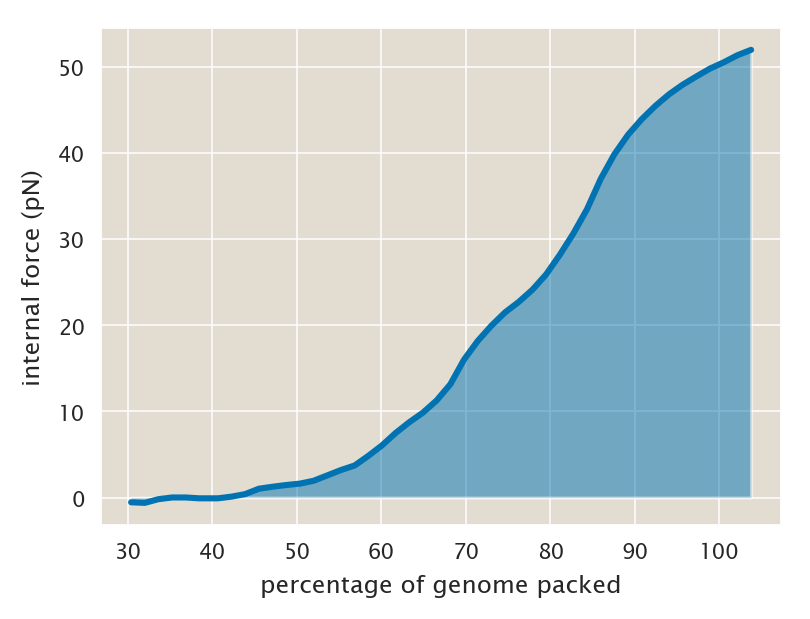

In [9]:
# Import data
df_force = pd.read_excel('../data/fig10.19B.xls', sheet_name='tidy')

# Plot data
plt.plot(df_force.percentage_packed,
         df_force.force_pN, lw=2)

# Fill betwee curve and x axis
plt.fill_between(df_force.percentage_packed,
                 df_force.force_pN,
                 alpha=0.5)

# Label axis
plt.xlabel('percentage of genome packed')
_ = plt.ylabel('internal force (pN)')

Now that we imported the data we are ready to compare it with our theoretical result. We know the persistence length $\xi_p$, we know the radius of the phage $\phi$ 29 $R_{out}$, the length of it's genome $L$, and we just determined the parameters for the osmotic pressure $F_o$ and $c$. The only parameter that we do not know is the spacing between DNA strands $d_s$.

The approach we will take to determine this parameter makes the assumption that the DNA that has already being packed reaches an equilibrium inside the capside. What this allows us to do is to numerically find for each value of $L$ the value of $d_s$ that minimizes the free energy. This is equivalent to computing
$$
{\partial G_{virus} \over \partial d_s} \vert_{L} = 0.
$$
We could in principle compute this derivative using the `sympy` symbolic package, but at the end of the day we would still find the value of $d_s$ that minimiazes the free energy numerically. So the approach we will take is to define the free energy function itself and just minimize such function for a given value of L. Let's go ahead and define this function.

In [10]:
def G_virus(ds, L, xi_p, Rout, kbt, Fo, c):
    '''
    Function to compute the free energy of packing the genome of a phage into a 
    spherical capsid.
    Parameters
    ----------
    ds : float.
        Distance between strands of DNA inside the capsid.
    L : float.
        Length of the genome
    xi_p : float.
        DNA persistence length
    Rout : float.
        Radius of spherical capsid
    kbt : float.
        Thermal energy scale
    Fo, c : floats.
        Empirical parameters associated with the charge interaction free energy
    '''
    
    # Define x value for bending free energy
    x = (3 * np.sqrt(3) * ds**2 * L / 8 / np.pi / Rout**3)**(2 / 3)
    
    # Compute bending free energy
    G_bend = 4 * np.pi * xi_p * kbt / np.sqrt(3) / ds**2 * Rout *\
             (1 / 2 * np.log((1 + x) / (1 - x)) - x)
    
    # Compute charge interaction free energy
    G_charge = np.sqrt(3) * Fo * (c**2 + c * ds) * L * np.exp(- ds / c)
    
    # Return total free energy
    return G_bend + G_charge

Let's now define the numerical value for our parameters. All of this will be set in SI units.

In [11]:
# Persistence length
xi_p = 150 * (1 / 3) * 1E-9  # bp->nm->m

# Thermal energy
kbt = 4.1E-21  # pN nm -> Joules
# Phage dimensions from bionumbers
# https://bionumbers.hms.harvard.edu/search.aspx?task=searchbytrmorg&log=y&trm=Bacteriophage%20phi%2029
L = 19.3E3 * (1 / 3) * 1E-9  # bp->nm->m
Rout = 50 / 2 * 1E-9  # nm->m

Now we can use a minimization routine from `scipy` to systematically find the value of $d_s$ that minimizes the free energy as a function of $L$.

In [25]:
# Define array of values of L
L_array = np.linspace(0.1, 1, 100) * L

# Define array to save values of ds that minimize free energy
ds_array = np.zeros_like(L_array)

# Loop through values of length
for i, l in enumerate(L_array):
    # Set parameter values for this iteration
    param = (l, xi_p, Rout, kbt, Fo, c)
    
    # Minimize free energy function
    ds_array[i] = sp.optimize.minimize(G_virus, 3E-9, args=param,
                                       method='Powell').x
    

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


In [26]:
ds_array

array([199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27053004,
       199.27053004, 199.27053004, 199.27053004, 199.27